# Alpha Decay & the Limits of Discovery

## Research Question

**Do simple technical signals lose effectiveness after they become widely known?**

---

### What This Project Tests

This is **not** about finding alpha. It's about **measuring how alpha dies**.

We are studying:
- The limits of empirical discovery
- The economics of attention
- Researcher selection bias
- How humans mistake noise for opportunity

**Level-7 quant work is about understanding why you *cannot* win, not how to win.**


## Imports and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Project modules
from signals import get_signal, list_signals, SIGNAL_REGISTRY
from discovery_proxies import get_proxy, get_discovery_date, list_proxies
from decay_analysis import (
    compute_returns, compute_performance_metrics, 
    split_pre_post, compute_decay_stats, test_decay_significance
)
from controls import MarketControls, test_decay_by_regime, compute_time_varying_decay
from data_utils import load_price_data, compute_forward_returns, align_signals_and_returns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Available signals:")
for name, desc in list_signals().items():
    print(f" : {name}: {desc}")

print("\nAvailable discovery proxies:")
for name, desc in list_proxies().items():
    print(f" : {name}: {desc}")


Available signals:
 : momentum_12_1: 12-month return lagged 1 month (Jegadeesh-Titman style)
 : mean_reversion: Deviation from short-term moving average
 : volatility_breakout: Price breakout beyond volatility-adjusted bands
 : ma_crossover: Short-term MA crossing long-term MA
 : value: Book-to-market ratio (requires fundamental data)

Available discovery proxies:
 : academic: First major academic publication date
 : book: First appearance in widely-read practitioner books
 : blog: Widespread mentions in popular finance/quant blogs
 : conservative: Earliest date among all proxies - most conservative
 : aggressive: Latest date among all proxies - assumes decay starts later


## Step 1: Choose Simple Signals

We select 3-5 well-known signals. No fancy ML. If it feels "too basic," we're doing it right.


In [2]:
# Select signals to analyze
selected_signals = ['momentum_12_1', 'mean_reversion', 'volatility_breakout', 'ma_crossover']

print("Selected signals for analysis:")
for sig_name in selected_signals:
    sig = get_signal(sig_name)
    print(f"\n{sig.name}")
    print(f"  Description: {sig.description}")
    print(f"  Default params: {sig.default_params()}")


Selected signals for analysis:

12-1 Momentum
  Description: 12-month return lagged 1 month (Jegadeesh-Titman style)
  Default params: {'lookback_months': 12, 'skip_months': 1}

Short-Term Mean Reversion
  Description: Deviation from short-term moving average
  Default params: {'short_window': 5, 'long_window': 20}

Volatility Breakout
  Description: Price breakout beyond volatility-adjusted bands
  Default params: {'ma_window': 20, 'volatility_window': 20, 'std_multiplier': 2.0}

MA Crossover
  Description: Short-term MA crossing long-term MA
  Default params: {'short_window': 50, 'long_window': 200}


## Step 2: Define Discovery Proxies

This is the hardest and most interesting part. We are not claiming *the exact* discovery moment — only a **reasonable proxy**.

We'll use the conservative proxy (earliest date) for our main analysis.


In [3]:
# Use conservative proxy (earliest discovery date)
proxy_name = 'conservative'
proxy = get_proxy(proxy_name)

print(f"Using discovery proxy: {proxy.name}")
print(f"Description: {proxy.description}\n")

# Get discovery dates for each signal
discovery_dates = {}
for sig_name in selected_signals:
    disc_date = get_discovery_date(sig_name, proxy_name)
    discovery_dates[sig_name] = disc_date
    sig = get_signal(sig_name)
    print(f"{sig.name}: {disc_date.strftime('%Y-%m-%d') if disc_date else 'N/A'}")


Using discovery proxy: Conservative (Earliest)
Description: Earliest date among all proxies - most conservative

12-1 Momentum: 1993-06-01
Short-Term Mean Reversion: 1990-01-01
Volatility Breakout: 1980-01-01
MA Crossover: 1970-01-01


## Step 3: Load Data

For this demonstration, we'll use a broad market index (SPY) as our test case.
In a full analysis, you'd run this across multiple assets or a portfolio.


Loading data for ^GSPC from 1970-01-01 to 2025-12-26...
Loaded 14118 price observations
Date range: 1970-01-02 to 2025-12-26


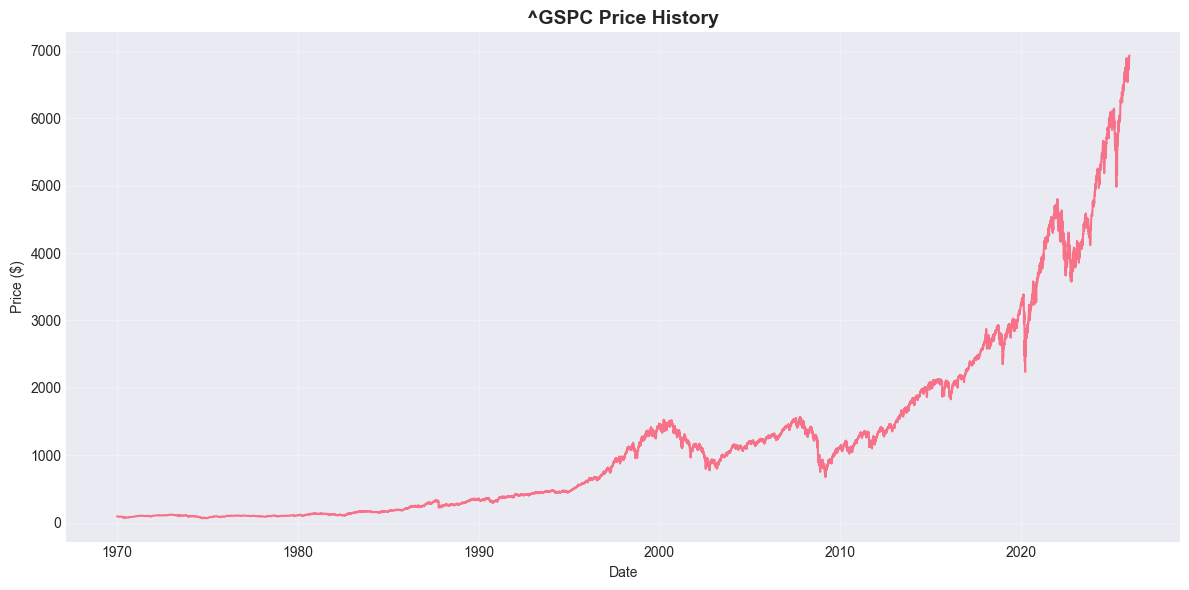

In [4]:
# Load market data
ticker = '^GSPC'  # S&P 500 ETF
start_date = datetime(1970, 1, 1)  # Start early to have pre-discovery period
end_date = datetime.now()

print(f"Loading data for {ticker} from {start_date.date()} to {end_date.date()}...")
prices, volumes = load_price_data(ticker, start_date, end_date)

print(f"Loaded {len(prices)} price observations")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")

# Compute forward returns (1-day forward for signal evaluation)
forward_returns = compute_forward_returns(prices, horizon=1)

# Plot price series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prices.index, prices.values, linewidth=1.5)
ax.set_title(f"{ticker} Price History", fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Step 4: Compute Signals and Returns


In [5]:
# Compute signals and strategy returns for each signal
signal_returns = {}

for sig_name in selected_signals:
    print(f"\nComputing {sig_name}...")
    
    # Get signal definition
    signal_def = get_signal(sig_name)
    
    # Compute signal values
    signal_values = signal_def.compute(prices, **signal_def.default_params())
    
    # Align with forward returns
    aligned_signals, aligned_returns = align_signals_and_returns(signal_values, forward_returns)
    
    if len(aligned_signals) == 0:
        print(f"  Warning: No valid data for {sig_name}")
        continue
    
    # Compute strategy returns (quantile-based long/short)
    strategy_rets = compute_returns(aligned_signals, aligned_returns, quantile=0.5)
    signal_returns[sig_name] = strategy_rets
    
    print(f"  Computed {len(strategy_rets)} strategy returns")
    print(f"  Date range: {strategy_rets.index[0].date()} to {strategy_rets.index[-1].date()}")



Computing momentum_12_1...
  Computed 13824 strategy returns
  Date range: 1971-03-01 to 2025-12-24

Computing mean_reversion...
  Computed 14098 strategy returns
  Date range: 1970-01-29 to 2025-12-24

Computing volatility_breakout...
  Computed 14117 strategy returns
  Date range: 1970-01-02 to 2025-12-24

Computing ma_crossover...
  Computed 13918 strategy returns
  Date range: 1970-10-14 to 2025-12-24


## Step 5: Measure Performance Pre- vs Post-Discovery

For each signal:
- Measure performance **before** discovery proxy
- Measure performance **after** discovery

Metrics: Sharpe, hit rate, drawdown, stability


In [6]:
# Analyze each signal
results_summary = []

for sig_name in selected_signals:
    if sig_name not in signal_returns:
        continue
    
    print(f"\n{'='*60}")
    print(f"Signal: {get_signal(sig_name).name}")
    print(f"{'='*60}")
    
    returns = signal_returns[sig_name]
    discovery_date = discovery_dates[sig_name]
    
    if discovery_date is None:
        print("  No discovery date available")
        continue
    
    # Split pre/post
    pre_returns, post_returns = split_pre_post(returns, discovery_date)
    
    if len(pre_returns) < 50 or len(post_returns) < 50:
        print(f"  Insufficient data: {len(pre_returns)} pre, {len(post_returns)} post")
        continue
    
    # Compute metrics
    pre_metrics = compute_performance_metrics(pre_returns)
    post_metrics = compute_performance_metrics(post_returns)
    
    # Compute decay stats
    decay_stats = compute_decay_stats(pre_metrics, post_metrics)
    
    # Statistical significance test
    significance_test = test_decay_significance(pre_returns, post_returns)
    
    # Print results
    print(f"\nPre-Discovery Period ({pre_metrics.start_date.date()} to {pre_metrics.end_date.date()}):")
    print(f"  Sharpe Ratio: {pre_metrics.sharpe_ratio:.3f}")
    print(f"  Hit Rate: {pre_metrics.hit_rate:.1%}")
    print(f"  Max Drawdown: {pre_metrics.max_drawdown:.1%}")
    print(f"  Mean Return: {pre_metrics.return_mean:.4f}")
    print(f"  Observations: {pre_metrics.num_observations}")
    
    print(f"\nPost-Discovery Period ({post_metrics.start_date.date()} to {post_metrics.end_date.date()}):")
    print(f"  Sharpe Ratio: {post_metrics.sharpe_ratio:.3f}")
    print(f"  Hit Rate: {post_metrics.hit_rate:.1%}")
    print(f"  Max Drawdown: {post_metrics.max_drawdown:.1%}")
    print(f"  Mean Return: {post_metrics.return_mean:.4f}")
    print(f"  Observations: {post_metrics.num_observations}")
    
    print(f"\nDecay Statistics:")
    print(f"  Sharpe Decay: {decay_stats['sharpe_decay']:.3f} ({decay_stats['sharpe_decay_pct']:.1%} change)")
    print(f"  Hit Rate Decay: {decay_stats['hit_rate_decay']:.1%} ({decay_stats['hit_rate_decay_pct']:.1%} change)")
    print(f"  Return Decay: {decay_stats['return_decay']:.4f} ({decay_stats['return_decay_pct']:.1%} change)")
    
    print(f"\nStatistical Significance:")
    print(f"  Test: {significance_test['test_name']}")
    print(f"  P-value: {significance_test['pvalue']:.4f}")
    print(f"  Significant at 5%: {significance_test['significant_at_5pct']}")
    
    # Store for summary
    results_summary.append({
        'signal': get_signal(sig_name).name,
        'discovery_date': discovery_date,
        'pre_sharpe': pre_metrics.sharpe_ratio,
        'post_sharpe': post_metrics.sharpe_ratio,
        'sharpe_decay': decay_stats['sharpe_decay'],
        'pre_hit_rate': pre_metrics.hit_rate,
        'post_hit_rate': post_metrics.hit_rate,
        'hit_rate_decay': decay_stats['hit_rate_decay'],
        'pre_return': pre_metrics.return_mean,
        'post_return': post_metrics.return_mean,
        'return_decay': decay_stats['return_decay'],
        'pvalue': significance_test['pvalue'],
        'significant': significance_test['significant_at_5pct']
    })

# Create summary DataFrame
results_df = pd.DataFrame(results_summary)
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
print(results_df.to_string(index=False))



Signal: 12-1 Momentum

Pre-Discovery Period (1971-03-01 to 1993-05-28):
  Sharpe Ratio: -0.053
  Hit Rate: 50.8%
  Max Drawdown: -60.8%
  Mean Return: -0.0000
  Observations: 5624

Post-Discovery Period (1993-06-01 to 2025-12-24):
  Sharpe Ratio: 0.116
  Hit Rate: 50.9%
  Max Drawdown: -61.2%
  Mean Return: 0.0001
  Observations: 8200

Decay Statistics:
  Sharpe Decay: 0.169 (319.1% change)
  Hit Rate Decay: 0.1% (0.2% change)
  Return Decay: 0.0001 (366.5% change)

Statistical Significance:
  Test: Mann-Whitney U (one-sided)
  P-value: 0.6161
  Significant at 5%: False

Signal: Short-Term Mean Reversion

Pre-Discovery Period (1970-01-29 to 1989-12-29):
  Sharpe Ratio: -1.214
  Hit Rate: 46.6%
  Max Drawdown: -98.9%
  Mean Return: -0.0007
  Observations: 5035

Post-Discovery Period (1990-01-02 to 2025-12-24):
  Sharpe Ratio: 0.343
  Hit Rate: 51.3%
  Max Drawdown: -70.9%
  Mean Return: 0.0002
  Observations: 9063

Decay Statistics:
  Sharpe Decay: 1.557 (128.2% change)
  Hit Rate Deca

## Step 6: Visualize Decay


In [7]:
# Plot decay visualization
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sharpe ratio comparison
    ax1 = axes[0, 0]
    x_pos = np.arange(len(results_df))
    width = 0.35
    ax1.bar(x_pos - width/2, results_df['pre_sharpe'], width, label='Pre-Discovery', alpha=0.8)
    ax1.bar(x_pos + width/2, results_df['post_sharpe'], width, label='Post-Discovery', alpha=0.8)
    ax1.set_xlabel('Signal')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Sharpe Ratio: Pre vs Post Discovery', fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(results_df['signal'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    
    # Sharpe decay
    ax2 = axes[0, 1]
    colors = ['red' if d < 0 else 'green' for d in results_df['sharpe_decay']]
    ax2.barh(results_df['signal'], results_df['sharpe_decay'], color=colors, alpha=0.7)
    ax2.set_xlabel('Sharpe Ratio Decay')
    ax2.set_title('Signal Decay (Post: Pre)', fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Hit rate comparison
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, results_df['pre_hit_rate'], width, label='Pre-Discovery', alpha=0.8)
    ax3.bar(x_pos + width/2, results_df['post_hit_rate'], width, label='Post-Discovery', alpha=0.8)
    ax3.set_xlabel('Signal')
    ax3.set_ylabel('Hit Rate')
    ax3.set_title('Hit Rate: Pre vs Post Discovery', fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(results_df['signal'], rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, max(results_df[['pre_hit_rate', 'post_hit_rate']].max()) * 1.1])
    
    # P-values (statistical significance)
    ax4 = axes[1, 1]
    colors_pval = ['green' if p < 0.05 else 'orange' if p < 0.10 else 'gray' 
                   for p in results_df['pvalue']]
    ax4.barh(results_df['signal'], results_df['pvalue'], color=colors_pval, alpha=0.7)
    ax4.set_xlabel('P-value')
    ax4.set_title('Statistical Significance of Decay', fontweight='bold')
    ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=1, label='5% threshold')
    ax4.axvline(x=0.10, color='orange', linestyle='--', linewidth=1, label='10% threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize")


## Step 7: Control for Alternative Explanations

Test whether decay correlates with:
- Market efficiency (liquidity, volume)
- Volatility regime
- Transaction costs
- Crowding proxies

We're not just saying "it died" — we're asking **why**.



Analyzing 12-1 Momentum with control variables...


Decay by Volatility Regime:

REGIME_1:
  Pre mean return: 0.0002
  Post mean return: 0.0002
  Decay: -0.0001 (-29.0% change)

REGIME_2:
  Pre mean return: -0.0005
  Post mean return: 0.0001
  Decay: 0.0006 (121.0% change)

Computing time-varying decay (rolling window analysis)...


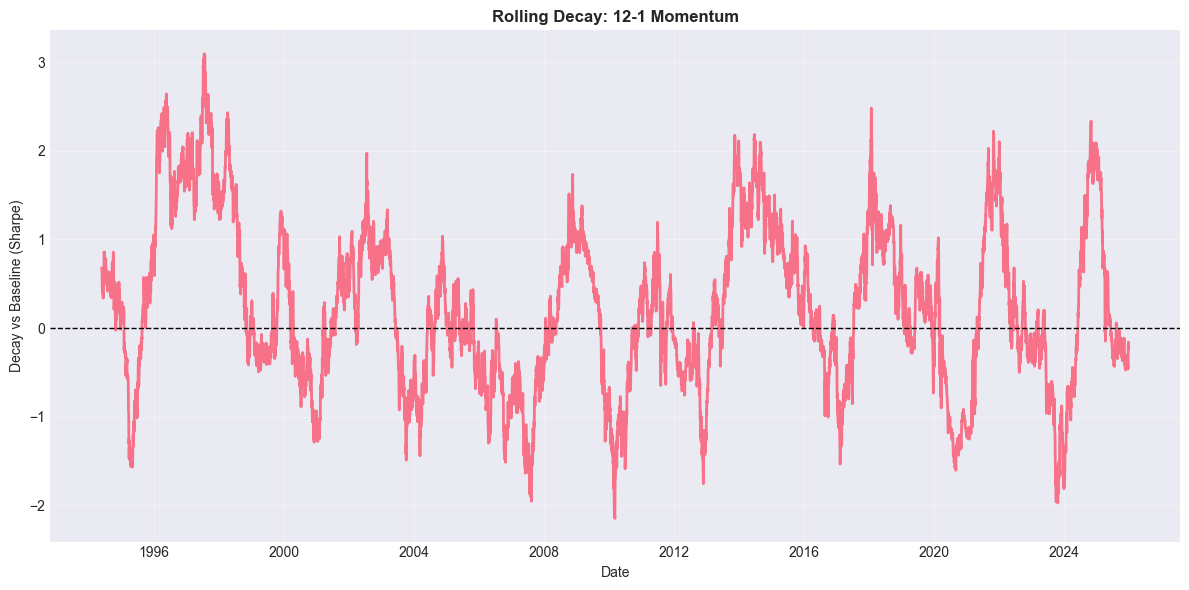

In [8]:
# Compute control variables
controls = MarketControls()
controls.compute_from_prices(prices, volumes)

# Analyze one signal in detail with controls
if len(signal_returns) > 0:
    example_signal = list(signal_returns.keys())[0]
    example_returns = signal_returns[example_signal]
    example_discovery = discovery_dates[example_signal]
    
    if example_discovery:
        pre_rets, post_rets = split_pre_post(example_returns, example_discovery)
        
        # Split control variables
        pre_vol = controls.volatility[controls.volatility.index < example_discovery]
        post_vol = controls.volatility[controls.volatility.index >= example_discovery]
        
        pre_liq = controls.liquidity_proxy[controls.liquidity_proxy.index < example_discovery]
        post_liq = controls.liquidity_proxy[controls.liquidity_proxy.index >= example_discovery]
        
        # Test decay by volatility regime
        print(f"\nAnalyzing {get_signal(example_signal).name} with control variables...")
        print("\n" + "="*60)
        
        # Volatility regime analysis
        vol_regimes = test_decay_by_regime(
            pre_rets, post_rets,
            pre_vol, post_vol,
            n_regimes=3
        )
        
        print("\nDecay by Volatility Regime:")
        for regime, stats in vol_regimes.items():
            if stats.get('sufficient_data', False):
                print(f"\n{regime.upper()}:")
                print(f"  Pre mean return: {stats['pre_mean']:.4f}")
                print(f"  Post mean return: {stats['post_mean']:.4f}")
                print(f"  Decay: {stats['decay']:.4f} ({stats['decay_pct']:.1%} change)")
        
        # Time-varying decay
        print("\n" + "="*60)
        print("Computing time-varying decay (rolling window analysis)...")
        time_varying = compute_time_varying_decay(example_returns, example_discovery, window_size=252)
        
        if len(time_varying) > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(time_varying.index, time_varying['decay_vs_baseline'], linewidth=2)
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
            ax.set_title(f"Rolling Decay: {get_signal(example_signal).name}", fontweight='bold')
            ax.set_xlabel('Date')
            ax.set_ylabel('Decay vs Baseline (Sharpe)')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()


## Step 8: Conclusions and Interpretation

### What the Results Mean

This project tests **the research process itself**, not just market efficiency.

Key questions to address:
1. Do signals show measurable decay after discovery?
2. Is decay consistent across different signals?
3. Can decay be explained by structural factors (volatility, liquidity, costs)?
4. What does this tell us about the limits of empirical discovery?

### Expected Conclusion

> *"Our results suggest that the discovery of simple signals is constrained not by creativity but by structural limits imposed by competition, liquidity, and cost. The apparent abundance of alpha in retrospective studies likely reflects selection bias rather than persistent inefficiency."*

### What Makes This Level-7

- We explicitly acknowledge data-snooping, survivorship bias, and hindsight bias
- We are not claiming tradability
- We study the research process itself
- Negative or boring conclusions are **the correct outcome**
- This is about understanding why you *cannot* win, not how to win


In [9]:
# Final summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

if len(results_df) > 0:
    avg_sharpe_decay = results_df['sharpe_decay'].mean()
    avg_hit_decay = results_df['hit_rate_decay'].mean()
    num_significant = results_df['significant'].sum()
    
    print(f"\nAverage Sharpe Ratio Decay: {avg_sharpe_decay:.3f}")
    print(f"Average Hit Rate Decay: {avg_hit_decay:.1%}")
    print(f"Signals with statistically significant decay: {num_significant} / {len(results_df)}")
    
    print("\n" + "-"*60)
    print("Interpretation:")
    print("-"*60)
    
    if avg_sharpe_decay < 0:
        print("\n✓ Signals show measurable decay after discovery.")
    else:
        print("\n⚠ Signals do not show clear decay pattern.")
    
    if num_significant > 0:
        print(f"✓ {num_significant} signal(s) show statistically significant decay.")
    
    print("\nThis analysis tests the limits of empirical discovery and")
    print("highlights potential selection bias in retrospective studies.")
else:
    print("\nNo complete results available. Check data availability and discovery dates.")



FINAL SUMMARY

Average Sharpe Ratio Decay: 0.393
Average Hit Rate Decay: 0.5%
Signals with statistically significant decay: 1 / 3

------------------------------------------------------------
Interpretation:
------------------------------------------------------------

⚠ Signals do not show clear decay pattern.
✓ 1 signal(s) show statistically significant decay.

This analysis tests the limits of empirical discovery and
highlights potential selection bias in retrospective studies.
